### Nested Fixed-Point Algorithm (NFXP)

#### Problem Setup
The goal is to estimate the reward parameters $\theta = [\theta_1, \theta_2, \theta_3]$ of a Markov Decision Process (MDP) from observed expert trajectories.

---

#### Reward Function
The reward at a state $s$ is determined by the feature associated with that state:
$
R(s) = \theta_1 \cdot \phi_1(s) + \theta_2 \cdot \phi_2(s) + \theta_3 \cdot \phi_3(s),
$
where $\phi_1, \phi_2, \phi_3$ represent features of the gridworld environment.

---

#### Value Function
The value function for a state $s$ is computed using the Bellman equation:
$
V(s) = \log \sum_a \exp \left[ R(s, a) + \gamma \cdot V(s') \right],
$
where:
- $R(s, a)$: immediate reward for taking action $a$ from state $s$,
- $\gamma$: discount factor,
- $s'$: next state after taking action $a$.

The softmax (log-sum-exp) accounts for stochastic policies.

---

#### Log-Likelihood of Observed Trajectories
The likelihood of observing a trajectory $\tau = \{(s_t, a_t, r_t)\}_{t=0}^T$ is:
$
\mathcal{L}(\theta) = \prod_{t=0}^T P(a_t | s_t; \theta),
$
where:
$
P(a | s; \theta) = \frac{\exp(Q(s, a; \theta))}{\sum_{a'} \exp(Q(s, a'; \theta))}.
$

---

#### Objective Function
To estimate $\theta$, maximize the log-likelihood:
$
\max_{\theta} \quad \sum_{\tau \in \mathcal{D}} \sum_{t=0}^T \log P(a_t | s_t; \theta),
$
where $\mathcal{D}$ is the set of expert trajectories.

---

#### Nested Fixed-Point Algorithm (NFXP)
1. Inner Loop: Solve the value function $V(s)$ for fixed $\theta$ using value iteration.
2. Outer Loop: Update $\theta$ to maximize the log-likelihood using gradient-based optimization:
   $ 
   \theta \gets \arg\min_{\theta} -\mathcal{L}(\theta).
   $
3. Convergence: Repeat until $\|\theta_{k+1} - \theta_k\| < \epsilon$.

---

#### Experimental Setup
- GridWorld Environment: A $5 \times 5$ grid with three features:
  - Feature 1: $\phi_1(s)$ with reward $\theta_1 = 1.0$,
  - Feature 2: $\phi_2(s)$ with reward $\theta_2 = 0.95$,
  - Feature 3: $\phi_3(s)$ with reward $\theta_3 = -1.0$.
- Expert Data: Generate $n_t$ trajectories from an expert policy.
- Estimation: Recover $\theta$ using NFXP.

---

#### Visualization
1. Reward Maps:
   - Heatmaps of true and recovered reward functions.
2. Optimal Policy:
   - Grid of arrows showing actions under the true and recovered rewards.

---

#### Iterative Algorithm Summary
1. Initialize $\theta$ and generate value function $V(s)$.
2. For each trajectory:
   - Compute action probabilities $P(a | s; \theta)$.
   - Accumulate log-likelihood.
3. Optimize $\theta$ to maximize log-likelihood.
4. Iterate until convergence.

Completed nt=10, trial=1/20
Completed nt=10, trial=2/20
Completed nt=10, trial=3/20
Completed nt=10, trial=4/20
Completed nt=10, trial=5/20
Completed nt=10, trial=6/20
Completed nt=10, trial=7/20
Completed nt=10, trial=8/20
Completed nt=10, trial=9/20
Completed nt=10, trial=10/20
Completed nt=10, trial=11/20
Completed nt=10, trial=12/20
Completed nt=10, trial=13/20
Completed nt=10, trial=14/20
Completed nt=10, trial=15/20
Completed nt=10, trial=16/20
Completed nt=10, trial=17/20
Completed nt=10, trial=18/20
Completed nt=10, trial=19/20
Completed nt=10, trial=20/20
Completed nt=15, trial=1/20
Completed nt=15, trial=2/20
Completed nt=15, trial=3/20
Completed nt=15, trial=4/20
Completed nt=15, trial=5/20
Completed nt=15, trial=6/20
Completed nt=15, trial=7/20
Completed nt=15, trial=8/20
Completed nt=15, trial=9/20
Completed nt=15, trial=10/20
Completed nt=15, trial=11/20
Completed nt=15, trial=12/20
Completed nt=15, trial=13/20
Completed nt=15, trial=14/20
Completed nt=15, trial=15/20
Com

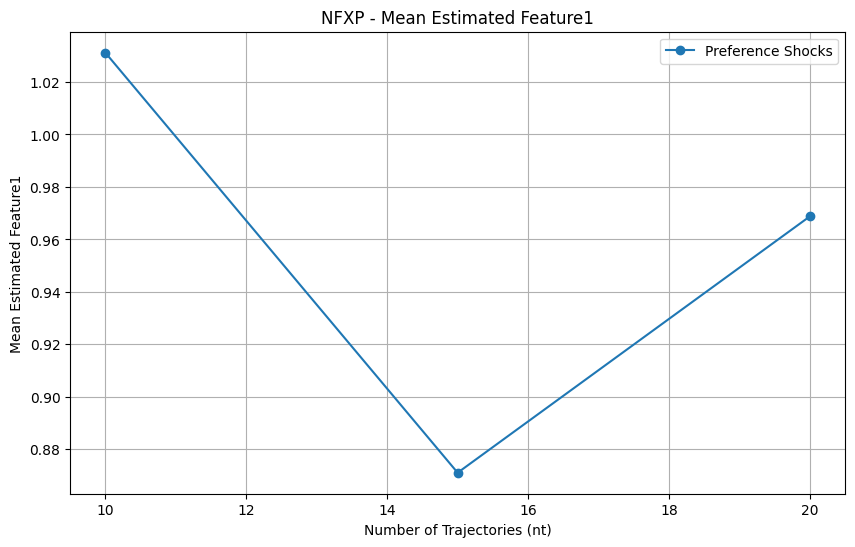

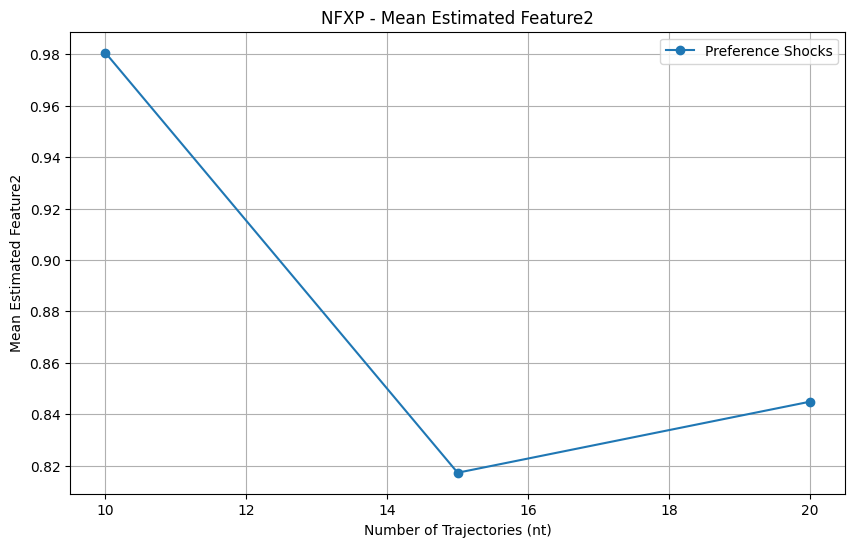

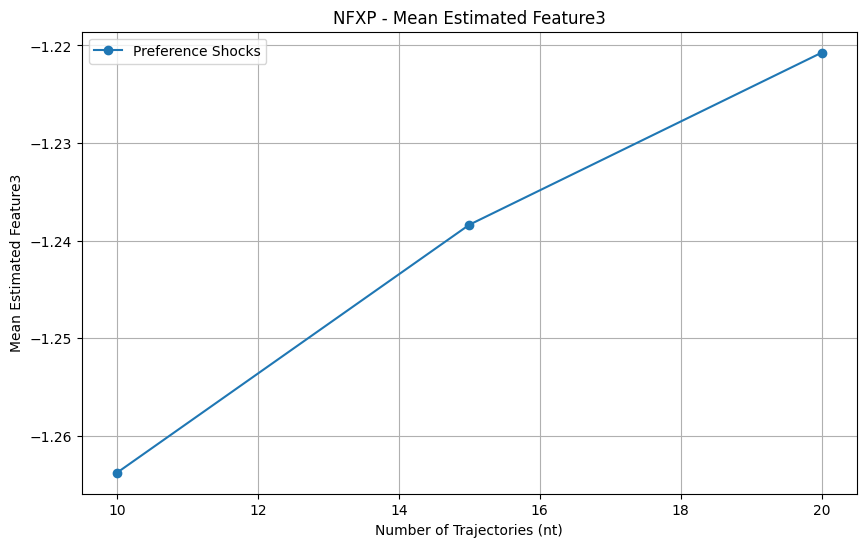

In [2]:
import numpy as np
import random
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define the GridWorld environment
class GridWorld:
    def __init__(self, size=5):
        self.size = size  # Grid size (5x5)
        self.features = np.zeros((size, size))
        self.payoffs = {}
        self.define_features()
        self.states = [(x, y) for x in range(size) for y in range(size)]
    
    def define_features(self):
        # Define features and their payoffs
        # Feature 1: Payoff = 1
        # Feature 2: Payoff = 0.95
        # Feature 3: Payoff = -1
        for x in range(self.size):
            for y in range(self.size):
                if (x + y) % 3 == 0:
                    self.features[x, y] = 1  # Feature 1
                elif (x + y) % 3 == 1:
                    self.features[x, y] = 2  # Feature 2
                else:
                    self.features[x, y] = 3  # Feature 3
        self.payoffs = {1: 1, 2: 0.95, 3: -1}
    
    def get_payoff(self, position):
        x, y = position
        feature = self.features[x, y]
        return self.payoffs[feature]

# Define the Agent class
class Agent:
    def __init__(self, gridworld, discount_factor=0.95):
        self.gridworld = gridworld
        self.discount_factor = discount_factor
        self.actions = ['up', 'down', 'left', 'right', 'stay']
        self.num_actions = len(self.actions)
        self.states = gridworld.states
        self.state_indices = {state: idx for idx, state in enumerate(self.states)}
        self.num_states = len(self.states)
    
    def move(self, position, action):
        x, y = position
        if action == 'up' and x > 0:
            x -= 1
        elif action == 'down' and x < self.gridworld.size - 1:
            x += 1
        elif action == 'left' and y > 0:
            y -= 1
        elif action == 'right' and y < self.gridworld.size - 1:
            y += 1
        # 'stay' or invalid moves result in no change
        return (x, y)
    
    def value_iteration(self, max_iter=1000, tol=1e-7):
        V = np.zeros(self.num_states)
        for iteration in range(max_iter):
            V_prev = V.copy()
            for idx, state in enumerate(self.states):
                action_values = []
                for action in self.actions:
                    new_state = self.move(state, action)
                    reward = self.gridworld.get_payoff(new_state)
                    new_state_idx = self.state_indices[new_state]
                    Q_value = reward + self.discount_factor * V_prev[new_state_idx]
                    action_values.append(Q_value)
                # Correctly update V(s) using the Bellman equation
                V[idx] = logsumexp(action_values)
            # Check for convergence
            if np.max(np.abs(V - V_prev)) < tol:
                break
        return V
    
    def get_action_probabilities(self, state, V):
        action_values = []
        for action in self.actions:
            new_state = self.move(state, action)
            reward = self.gridworld.get_payoff(new_state)
            new_state_idx = self.state_indices[new_state]
            Q_value = reward + self.discount_factor * V[new_state_idx]
            action_values.append(Q_value)
        # Compute choice probabilities using softmax
        log_probs = action_values - logsumexp(action_values)
        probs = np.exp(log_probs)
        return probs

# Function to generate a trajectory based on the process type
def generate_trajectory(agent, start_position, process_type='preference_shocks', max_steps=10):
    trajectory = []
    position = start_position
    # Compute the true value function using true parameters
    agent.gridworld.payoffs = {1: 1, 2: 0.95, 3: -1}
    V = agent.value_iteration()
    for step in range(max_steps):
        probs = agent.get_action_probabilities(position, V)
        action = np.random.choice(agent.actions, p=probs)
        new_position = agent.move(position, action)
        reward = agent.gridworld.get_payoff(new_position)
        trajectory.append((position, action, reward))
        position = new_position
    return trajectory

# Generate expert data (nt trajectories)
def generate_expert_data(agent, nt):
    trajectories = []
    grid_size = agent.gridworld.size
    # Set the gridworld payoffs to true parameters
    agent.gridworld.payoffs = {1: 1, 2: 0.95, 3: -1}
    V_true = agent.value_iteration()
    for _ in range(nt):
        start_position = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
        trajectory = []
        position = start_position
        for step in range(10):  # Assuming max_steps=10
            probs = agent.get_action_probabilities(position, V_true)
            action = np.random.choice(agent.actions, p=probs)
            new_position = agent.move(position, action)
            reward = agent.gridworld.get_payoff(new_position)
            trajectory.append((position, action, reward))
            position = new_position
        trajectories.append(trajectory)
    return trajectories

# NFXP Algorithm with corrected likelihood computation
def nfxp_log_likelihood(params, agent, trajectories):
    # Set gridworld payoffs based on parameters
    agent.gridworld.payoffs = {1: params[0], 2: params[1], 3: params[2]}
    # Solve for value function V
    V = agent.value_iteration()
    # Compute log-likelihood
    log_likelihood = 0
    for trajectory in trajectories:
        for (position, action, reward) in trajectory:
            probs = agent.get_action_probabilities(position, V)
            action_index = agent.actions.index(action)
            # Add a small epsilon to prevent log(0)
            log_likelihood += np.log(probs[action_index] + 1e-12)
    return -log_likelihood  # Negative log-likelihood for minimization

def estimate_nfxp(agent, trajectories):
    initial_params = [0.5, 0.5, -0.5]  # Alternative initial parameters
    bounds = [(-2, 2), (-2, 2), (-2, 2)]  # Adjusted bounds
    result = minimize(
        nfxp_log_likelihood,
        initial_params,
        args=(agent, trajectories),
        bounds=bounds,
        method='L-BFGS-B',
        options={'maxiter': 1000, 'disp': False}
    )
    estimated_params = result.x
    return estimated_params

# Run experiments
def run_experiment(nt_list=[10, 15, 20], num_trials=20):
    gridworld = GridWorld()
    agent = Agent(gridworld)
    results = defaultdict(list)
    for nt in nt_list:
        for trial in range(num_trials):
            trajectories = generate_expert_data(agent, nt)
            # NFXP estimation
            nfxp_estimates = estimate_nfxp(agent, trajectories)
            results['nfxp'].append((nt, trial, 'preference_shocks', nfxp_estimates))
            print(f"Completed nt={nt}, trial={trial+1}/{num_trials}")
    return results

# Function to compute mean estimates and errors
def compute_mean_estimates(df, algorithm_name):
    # True parameter values
    true_params = np.array([1, 0.95, -1])
    # Process preference_shocks
    pref_shocks_df = df[df['process_type'] == 'preference_shocks']
    mean_estimates_pref = pref_shocks_df.groupby('nt')[['Feature1', 'Feature2', 'Feature3']].mean()
    mean_estimates_pref['Process_Type'] = 'Preference Shocks'
    # Compute errors
    for i, feature in enumerate(['Feature1', 'Feature2', 'Feature3']):
        mean_estimates_pref[f'Error_{feature}'] = mean_estimates_pref[feature] - true_params[i]
    print(f"\n{algorithm_name} - Mean Estimated Parameters under Preference Shocks:")
    print(mean_estimates_pref[['Feature1', 'Feature2', 'Feature3']])
    print(f"\n{algorithm_name} - Estimation Errors under Preference Shocks:")
    print(mean_estimates_pref[[f'Error_Feature1', f'Error_Feature2', f'Error_Feature3']])
    
    # Plotting
    for feature in ['Feature1', 'Feature2', 'Feature3']:
        plt.figure(figsize=(10, 6))
        subset = mean_estimates_pref
        plt.plot(subset.index, subset[feature], marker='o', label='Preference Shocks')
        plt.title(f'{algorithm_name} - Mean Estimated {feature}')
        plt.xlabel('Number of Trajectories (nt)')
        plt.ylabel(f'Mean Estimated {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Main execution
if __name__ == "__main__":
    results = run_experiment()
    
    # Access NFXP estimates
    nfxp_results = results['nfxp']
    nfxp_df = pd.DataFrame(nfxp_results, columns=['nt', 'trial', 'process_type', 'estimates'])
    nfxp_df[['Feature1', 'Feature2', 'Feature3']] = pd.DataFrame(nfxp_df['estimates'].tolist(), index=nfxp_df.index)
    nfxp_df.drop('estimates', axis=1, inplace=True)
    
    # Compute and display mean estimates for NFXP
    compute_mean_estimates(nfxp_df, 'NFXP')

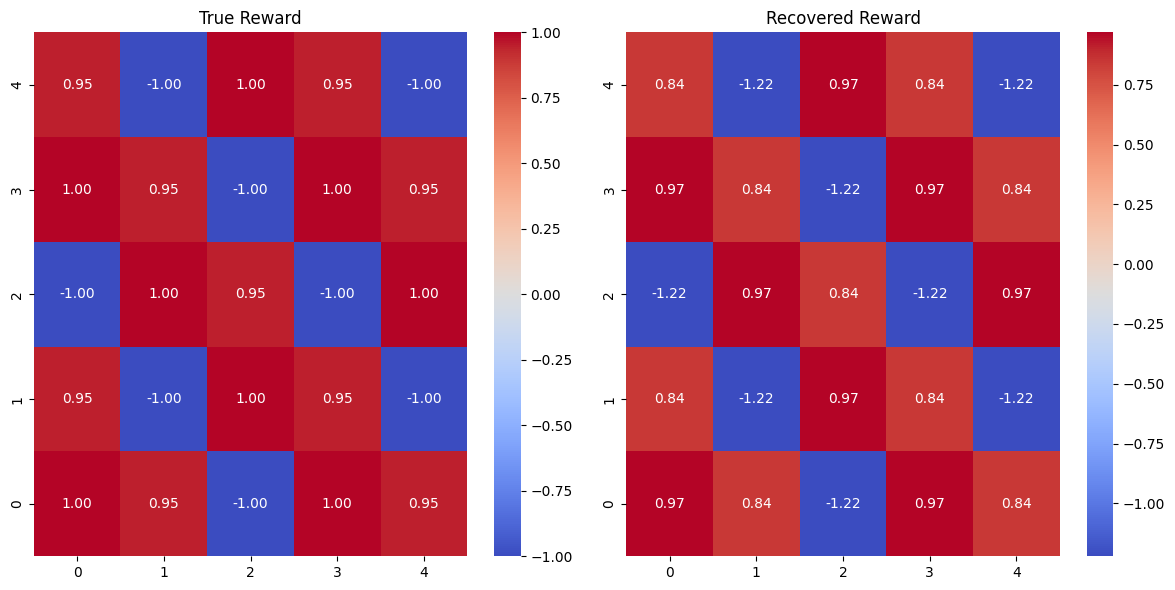

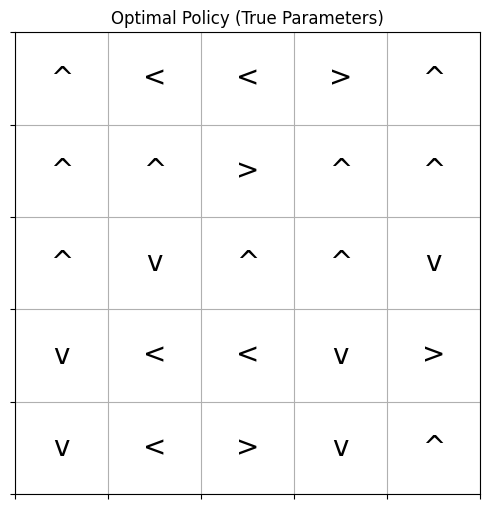

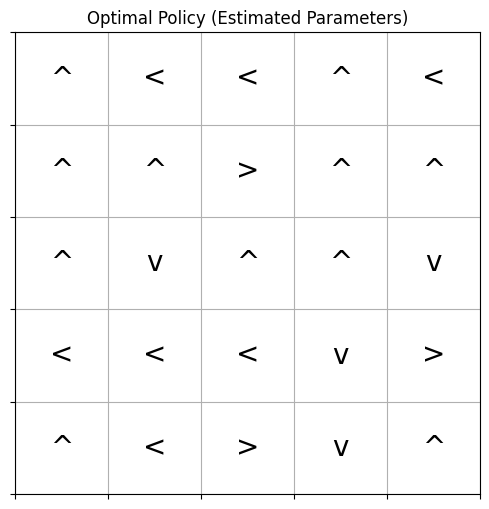

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# After compute_mean_estimates is done, we will:
# 1. Pick a particular nt to visualize (e.g., nt = 20)
# 2. Compute the mean estimated parameters for that nt
nt_to_visualize = 20
mean_params = nfxp_df[nfxp_df['nt'] == nt_to_visualize][['Feature1', 'Feature2', 'Feature3']].mean()

# True parameters
true_params = np.array([1.0, 0.95, -1.0])

# Create a new agent/gridworld for visualization
vis_gridworld = GridWorld()
vis_agent = Agent(vis_gridworld)

# Set the gridworld payoffs to true parameters and compute V_true
vis_agent.gridworld.payoffs = {1: true_params[0], 2: true_params[1], 3: true_params[2]}
V_true = vis_agent.value_iteration()

# Set the gridworld payoffs to recovered parameters and compute V_est
vis_agent.gridworld.payoffs = {1: mean_params['Feature1'], 2: mean_params['Feature2'], 3: mean_params['Feature3']}
V_est = vis_agent.value_iteration()

# Extract the true reward map and recovered reward map for all states
def get_reward_map(agent):
    reward_map = np.zeros((agent.gridworld.size, agent.gridworld.size))
    for x in range(agent.gridworld.size):
        for y in range(agent.gridworld.size):
            reward_map[x, y] = agent.gridworld.get_payoff((x, y))
    return reward_map

# Reset to true payoffs to get the true reward map
vis_agent.gridworld.payoffs = {1: true_params[0], 2: true_params[1], 3: true_params[2]}
true_reward_map = get_reward_map(vis_agent)

# Set to estimated payoffs to get the recovered reward map
vis_agent.gridworld.payoffs = {1: mean_params['Feature1'], 2: mean_params['Feature2'], 3: mean_params['Feature3']}
recovered_reward_map = get_reward_map(vis_agent)

# Plot true reward vs recovered reward
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(true_reward_map, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("True Reward")
axes[0].invert_yaxis()
sns.heatmap(recovered_reward_map, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Recovered Reward")
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

# Compute the optimal policy under true parameters and recovered parameters
# The policy is the action that has the highest probability in get_action_probabilities
def get_optimal_policy(agent, V):
    policy = {}
    for state in agent.states:
        probs = agent.get_action_probabilities(state, V)
        best_action_idx = np.argmax(probs)
        policy[state] = agent.actions[best_action_idx]
    return policy

# Reset to true payoffs and compute true policy
vis_agent.gridworld.payoffs = {1: true_params[0], 2: true_params[1], 3: true_params[2]}
V_true = vis_agent.value_iteration()
true_policy = get_optimal_policy(vis_agent, V_true)

# Set to estimated payoffs and compute estimated policy
vis_agent.gridworld.payoffs = {1: mean_params['Feature1'], 2: mean_params['Feature2'], 3: mean_params['Feature3']}
V_est = vis_agent.value_iteration()
est_policy = get_optimal_policy(vis_agent, V_est)

# Map actions to arrow directions for visualization
action_arrows = {
    'up': '^',
    'down': 'v',
    'left': '<',
    'right': '>',
    'stay': 'o'
}

def plot_policy(agent, policy, title):
    size = agent.gridworld.size
    fig, ax = plt.subplots(figsize=(6,6))
    # Create a grid of states
    for x in range(size):
        for y in range(size):
            a = policy[(x, y)]
            ax.text(y+0.5, x+0.5, action_arrows[a], ha='center', va='center', fontsize=20)
            # Draw grid lines
    ax.set_xticks(np.arange(size+1))
    ax.set_yticks(np.arange(size+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, size)
    ax.set_ylim(size, 0)
    ax.set_title(title)
    ax.grid(True)
    plt.show()

# Plot the optimal policies
plot_policy(vis_agent, true_policy, "Optimal Policy (True Parameters)")
plot_policy(vis_agent, est_policy, "Optimal Policy (Estimated Parameters)")
